# HW4: Structure-from-motion

Ref:

- https://blog.csdn.net/haizimin/article/details/49836077
- https://github.com/jesolem/PCV/blob/master/pcv_book/sfm.py
- multiple view geometry in computer vision
http://cvrs.whu.edu.cn/downloads/ebooks/Multiple%20View%20Geometry%20in%20Computer%20Vision%20(Second%20Edition).pdf

In [16]:
#%matplotlib notebook
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import hw3
np.set_printoptions(suppress=True)

In [17]:
test = np.array([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]])
u, s, v = np.linalg.svd(test)
print(u)
print(s)
print(v)
print(np.dot(np.dot(u,s),v))

[[-0.21483724  0.88723069  0.40824829]
 [-0.52058739  0.24964395 -0.81649658]
 [-0.82633754 -0.38794278  0.40824829]]
[ 16.84810335   1.06836951   0.        ]
[[-0.47967118 -0.57236779 -0.66506441]
 [-0.77669099 -0.07568647  0.62531805]
 [-0.40824829  0.81649658 -0.40824829]]
[ 13.73960403  -9.53300216   2.31195825]


## 讀取圖片

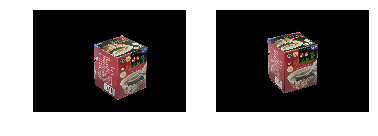

In [18]:
DEBUG_IMAGE_INDEX = 1

if(DEBUG_IMAGE_INDEX==1):
    image1 = cv2.imread('./data/Mesona1.JPG')
    image2 = cv2.imread('./data/Mesona2.JPG')
elif(DEBUG_IMAGE_INDEX == 2):
    image1 = cv2.imread('./data/Statue1.bmp')
    image2 = cv2.imread('./data/Statue2.bmp')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.subplot(121), plt.imshow(image1), plt.axis('off')
plt.subplot(122), plt.imshow(image2), plt.axis('off')
plt.show()

## 計算相機內部參數

In [19]:
intrinsic_matrix1 = np.zeros((3,3))
intrinsic_matrix1 = np.zeros((3,3))

if(DEBUG_IMAGE_INDEX == 1):
    intrinsic_matrix1 = np.array([[1.4219, 0.005, 0.5092],
                                  [0, 1.4219, 0.3802],
                                  [0, 0, 0.0010]])
    intrinsic_matrix1 = intrinsic_matrix1 / intrinsic_matrix1[2,2]
    intrinsic_matrix2 = intrinsic_matrix1
else:
    intrinsic_matrix1 = np.array([[5426.566895, 0.678017, 330.096680],
                 [0.000000, 5423.133301, 648.950012],
                 [0.000000, 0.000000, 1.000000]])

    intrinsic_matrix2 = np.array([[5426.566895, 0.678017, 387.430023],
                  [0.000000, 5423.133301, 620.616699],
                  [0.000000, 0.000000, 1.000000]])
print("Intrinsic Matrix 1\n", intrinsic_matrix1)
print("Intrinsic Matrix 2\n", intrinsic_matrix2)

Intrinsic Matrix 1
 [[ 1421.9     5.    509.2]
 [    0.   1421.9   380.2]
 [    0.      0.      1. ]]
Intrinsic Matrix 2
 [[ 1421.9     5.    509.2]
 [    0.   1421.9   380.2]
 [    0.      0.      1. ]]


## 計算特徵點

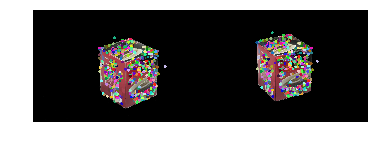

(<matplotlib.image.AxesImage at 0x146e4eeaa20>,
 (-0.5, 2399.5, 799.5, -0.5),
 None)

In [20]:
sift = cv2.xfeatures2d.SIFT_create()

(keypt1, desc1) = sift.detectAndCompute(image1, None)
(keypt2, desc2) = sift.detectAndCompute(image2, None)

BF_MACTHEr_DISTANCE = 0.65
matches = hw3.brute_force_matcher(desc1, desc2, BF_MACTHEr_DISTANCE)
matched_pt_order = hw3.sort_matched_points(matches)

matched_feature_image = hw3.show_matched_image(image1, image2, keypt1, keypt2, matched_pt_order, draw_line=False, circle_size=10)
plt.imshow(matched_feature_image), plt.axis('off'), plt.show()

## Fundamental and Essential Matrix

In [21]:
def get_normalization_matrix(pts):
    '''
        get the normalization matrix
    '''
    x_mean, y_mean = np.mean(pts, axis=0)
    x_var, y_var = np.var(pts, axis=0)    
    x_s, y_s = np.sqrt(2/x_var), np.sqrt(2/y_var)
    n = np.array([[x_s, 0, -x_s*x_mean], 
                  [0, y_s, -y_s*y_mean], 
                  [0, 0, 1]])
    
    return n.astype(np.float64)

def normalization(imgpts1, imgpts2):
    '''
        ref: lecture P.54
    '''
    # t1: image1 normalization matrix, t2: image2 normalization matrix
    t1, t2 = get_normalization_matrix(imgpts1), get_normalization_matrix(imgpts2)
    
    # to homography coordinate
    homopts1 = np.array([ [each[0], each[1], 1.0] for each in imgpts1])
    homopts2 = np.array([ [each[0], each[1], 1.0] for each in imgpts2])
    
    num_of_point = len(imgpts1)
    for i in range(num_of_point): 
        
        #最後一項要為1
        p2h = np.dot(t1, homopts1[i])
        homopts1[i] = p2h/p2h[-1]
        
        p2h1 = np.dot(t2, homopts2[i])
        homopts2[i] = p2h1/p2h1[-1]
    
    normalpts1 = np.delete(homopts1, -1, axis=1)
    normalpts2 = np.delete(homopts2, -1, axis=1)
    
    return normalpts1, normalpts2, t1, t2

def denormalize_fundamental_mat(normalmat1, normalmat2, normalize_fundamental):
    '''
        ref: Multiple View Geometry in Computer Vision - Algorithm 11.1
    '''
    transpose_normalmat2 = np.transpose(normalmat2)
    return np.dot(np.dot(transpose_normalmat2, normalize_fundamental), normalmat1)

def get_fundamental(samplept1, samplept2):
    '''
        ref: Multiple View Geometry in Computer Vision - Chapter 11.1, lecture P.50
    '''
    # normalization the key points
    normalpts1, normalpts2, nomalmat1, normalmat2 = normalization(samplept1, samplept2)
    
    A = np.zeros((len(normalpts1), 9), dtype=np.float64)
    for i in range(len(normalpts1)):
        x, y = normalpts1[i][0], normalpts1[i][1]
        xi, yi = normalpts2[i][0], normalpts2[i][1]
        A[i] = np.array([xi*x, xi*y, xi, yi*x, yi*y, yi, x, y, 1])
    
    # resolve det(f) = 0
    u, s, v = np.linalg.svd(A)
    F = v[np.argmin(s)]
    F = F.reshape(3, 3)
    u, s, v = np.linalg.svd(F)
    s = np.array([[s[0], 0 ,0],
                 [0, s[1], 0],
                 [0 , 0, 0]])
    F = np.dot(np.dot(u, s), v)
    
    # homographs coefficient and denormalize the fundamental matrix
    F = denormalize_fundamental_mat(nomalmat1, normalmat2, F)
    F = F/F[2,2]
    
    return F

def get_geometric_error(testpts1, testpts2, fundamentalmat, inliner_threshold):
    '''
        ref: Multiple View Geometry 11.4.3
    '''
    error = 0
    inliner_number = 0
    for i in range(len(testpts1)):
        
        # transform test points to homography coordinate
        x = np.array([testpts1[i][0], testpts1[i][1], 1])
        xi = np.array([testpts2[i][0], testpts2[i][1], 1])
        
        fx = np.dot(fundamentalmat, x)
        ftx = np.dot(np.transpose(fundamentalmat), xi)
        
        m = np.power(np.dot(np.dot(np.transpose(xi), fundamentalmat), x), 2)
        d = np.power(fx[0], 2) + np.power(fx[1], 2) + np.power(ftx[0], 2) + np.power(ftx[1], 2)
        
        distance = m/d
        error += distance
        if(distance < inliner_threshold):
            inliner_number += 1
            
    return error, inliner_number

def get_essential_mat(intrinsicmat1, intrinsicmat2, fundamentalmat):
    '''
        ref: Multiple View Geometry 9.12
    '''
    if(intrinsicmat1[-1,-1] != 1):
        intrinsicmat1 = intrinsicmat1 / intrinsicmat1[-1,-1]
    if(intrinsicmat2[-1,-1] != 1):
        intrinsicmat2 = intrinsicmat2 / intrinsicmat2[-1,-1]
        
    E = np.dot(np.dot(np.transpose(intrinsicmat2), fundamentalmat), intrinsicmat1)
    u, s, v = np.linalg.svd(E)
    m = (s[1]+s[2])/2
    s_ = np.array([[m, 0, 0],
                  [0, m, 0],
                  [0, 0, 0]])
    E = np.dot(np.dot(u, s_), v)
    
    return E
def find_fundamental_by_RANSAC(matchedpt_order, imgpts1, imgpts2, inliner_threshold):
    '''
        ref: Multiple View Geometry 11.6
    '''
    print("Key Point Number\n", len(imgpts1))
    ransac_iteration = 500
    ransac_sample_number = 8
    
    best_error = 0
    best_fundamental = np.zeros((3,3))
    best_inlinernum = 0
    best_sampts1, best_sampts2 = hw3.sample_match_points(matchedpt_order, imgpts1, imgpts2, ransac_sample_number)
    for i in range(ransac_iteration):
        sampts1, sampts2 = hw3.sample_match_points(matchedpt_order, imgpts1, imgpts2, ransac_sample_number)
        f = get_fundamental(sampts1, sampts2)
        error, inlinernum = get_geometric_error(imgpts1, imgpts2, f, inliner_threshold)
        if(inlinernum > best_inlinernum):
            best_error = error
            best_fundamental = f
            best_inlinernum = inlinernum
            best_sampts1, best_sampts2 = sampts1, sampts2
    best_essential = get_essential_mat(intrinsic_matrix1, intrinsic_matrix2, best_fundamental)
    print("RANSC Error\n", best_error)
    print("Inliner Number\n", best_inlinernum)
    return best_fundamental, best_essential, best_sampts1, best_sampts2 

RANSAC_INLINER_THRESHOLD = 0.25

# find the fundamnetal matrix
imgpts1, imgpts2 = hw3.get_matched_points(matched_pt_order, keypt1, keypt2)
fundamentamat, essentialmat, sampt1, sampt2 = find_fundamental_by_RANSAC(matched_pt_order, imgpts1, imgpts2, RANSAC_INLINER_THRESHOLD)
print("F\n", fundamentamat)
print("E\n", essentialmat)

# by opencv
fundamentalmat_opencv, _ = cv2.findFundamentalMat(imgpts1, imgpts2, cv2.RANSAC, RANSAC_INLINER_THRESHOLD, 0.99, None)
essentialmat_opencv = get_essential_mat(intrinsic_matrix1, intrinsic_matrix2, fundamentalmat_opencv)
cv_error, cv_inlinernum = get_geometric_error(imgpts1, imgpts2, fundamentalmat_opencv, RANSAC_INLINER_THRESHOLD)
print("CV RANSC Error\n", cv_error)
print("CV Inliner Number\n", cv_inlinernum)
print("F by opencv\n", fundamentalmat_opencv)
print("E by opencv\n", essentialmat_opencv)

Key Point Number
 595
RANSC Error
 451610.911275
Inliner Number
 228
F
 [[ 0.00000353  0.00003694 -0.02585223]
 [-0.0000429   0.00000046  0.06669089]
 [ 0.01975435 -0.05777641  1.        ]]
E
 [[  1.82581291  36.90259835  -5.777918  ]
 [-37.03630294   2.07635476  27.11749455]
 [  4.08147209 -27.47487684   0.28148517]]
CV RANSC Error
 464259.889443
CV Inliner Number
 297
F by opencv
 [[-0.00000027 -0.00000424  0.00024269]
 [ 0.00000383 -0.00000006  0.0134771 ]
 [-0.00078996 -0.01326626  1.        ]]
E by opencv
 [[ -0.28131151  -4.24215386  -1.08111548]
 [  3.86409706  -0.03197131  10.94135069]
 [  0.3619994  -10.86182258   0.29698866]]


## Draw Epipolar Lines

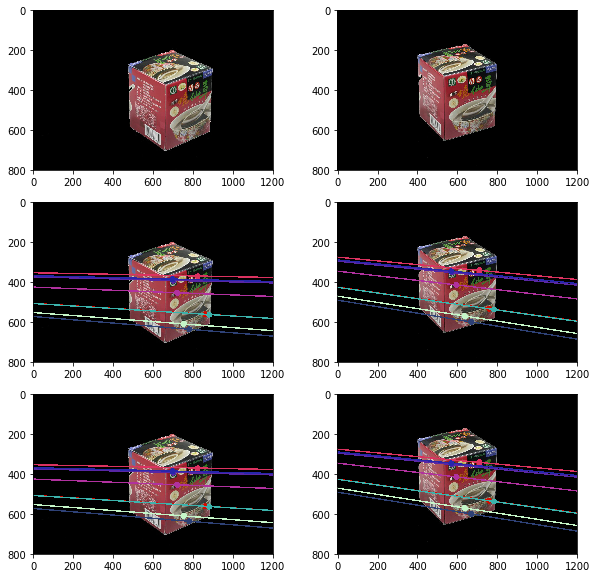

In [22]:
def compute_correspond_epilines(keypts, which_image, fundamental):
    '''
        ref: https://github.com/opencv/opencv/blob/f5801ee7dac4114ac2995a5fd3866ac7775752f7/modules/calib3d/src/fundam.cpp#L836
        l = Fx'
        l' = F^Tx
    '''
    lines = np.zeros((len(keypts), 3))
    
    if (which_image == 2):
        fundamental = np.transpose(fundamental)
    
    for i, p in enumerate(keypts):
        hp = np.array([p[0], p[1], 1])
        l = np.dot(fundamental, np.transpose(hp))
        
        a, b, c = l[0], l[1], l[2]
        check = a*a + b*b
        if check != 0:
            check = np.sqrt(check)
        else:
            check = 1
        lines[i] = np.array([a/check, b/check ,c/check])
        
    return lines

def draw_epilines(img1, img2, lines, pts1, pts2, colors):
    '''
        ref: https://docs.opencv.org/3.4.4/da/de9/tutorial_py_epipolar_geometry.html
        x0, y0 = (0, -b/c)
        x1, y1 = (w, -(aw+c)/b)
    '''
    imgA = np.copy(img1)
    imgB = np.copy(img2)
    h, w, _ = img1.shape
    
    i=0
    for r,pt1, pt2 in zip(lines, pts1, pts2):
        x0, y0 = (0, int(-r[2]/r[1]))
        x1, y1 = (w, int(-(r[0]*w+r[2])/r[1]))
        imgA = cv2.line(imgA, (x0, y0), (x1, y1), colors[i], 5)
        imgA = cv2.circle(imgA, (int(pt1[0]), int(pt1[1])), 15, colors[i], -1)
        imgB = cv2.circle(imgB, (int(pt2[0]), int(pt2[1])), 15, colors[i], -1)
        i += 1
    return imgA, imgB

colors = np.zeros((len(sampt1), 3))
for i in range(len(sampt1)):
    colors[i] = tuple(np.random.randint(0, 255, 3).tolist())

# show image epilines
lines1 = compute_correspond_epilines(sampt2, 2, fundamentalmat_opencv)
img3, _ = draw_epilines(image1, image2, lines1, sampt1, sampt2, colors)
lines2 = compute_correspond_epilines(sampt1, 1, fundamentalmat_opencv)
img4, _ = draw_epilines(image2, image1, lines2, sampt2, sampt1, colors)

# by opencv
lines3 = cv2.computeCorrespondEpilines(sampt2, 2, fundamentalmat_opencv)
lines3 = lines3.reshape(-1,3)
img5, _ = draw_epilines(image1, image2, lines3, sampt1, sampt2, colors)
lines4 = cv2.computeCorrespondEpilines(sampt1, 1, fundamentalmat_opencv)
lines4 = lines4.reshape(-1,3)
img6, _ = draw_epilines(image2, image1, lines4, sampt2, sampt1, colors)

plt.figure(figsize=(10, 10))
plt.subplot(321), plt.imshow(image1)
plt.subplot(322), plt.imshow(image2)
plt.subplot(323), plt.imshow(img3)
plt.subplot(324), plt.imshow(img4)
plt.subplot(325),plt.imshow(img5)
plt.subplot(326),plt.imshow(img6)
plt.show()

## Projection Matrix
project matirx = K[R|t] = 3x4

camera matrix = intrinsic matrix = k = 3x3

external rotation matrix = R = 3x3

translation matrix = t = 1x3

In [23]:
# first camera matrix (ref: Multiple View Geometry 9.19)
def check_coherent_rotatio(rotation):
    '''
        We can install a check to see if the
        rotation element is a valid rotation matrix. Keeping in mind that rotation matrices must have a
        determinant of 1 (or -1)
    '''
    if((abs(np.linalg.det(rotation)) - 1.0) > 1e-03):
        print('This is not a valid rotation matrix')
    return True

def get_camera_matrix(K, R, T):
    camera_matrix = np.zeros((3, 4))
    if(check_coherent_rotatio(R) == True):
        camera_matrix = np.array([[R[0,0], R[0,1], R[0,2], T[0]],
                           [R[1,0], R[1,1], R[1,2], T[1]],
                           [R[2,0], R[2,1], R[2,2], T[2]]])
    if(K[-1,-1] != 1):
        K = K/k[-1,-1]
#    camera_matrix = np.dot(K, camera_matrix)
#     if(camera_matrix[-1,-1] != 0):
#         camera_matrix = camera_matrix/camera_matrix[-1,-1]
    return camera_matrix

# camera 1 project matrix
I = np.array([[1, 0, 0],
             [0, 1, 0],
             [0, 0, 1]])
projectmat1 = get_camera_matrix(intrinsic_matrix1, I, [0, 0, 0])

answer_essentialmat = np.array([[ -0.04751557, -4.1136601, -2.78540049],
                               [1.83271582, -0.61888204 , 27.55997807],
                               [0.93858721, -26.90011109, 0.78394131]])

# skew-symmetric (ref: Multiple View Geometry 9.13)
U, _, V = np.linalg.svd(essentialmat_opencv)

W = np.array([[0, -1, 0], 
              [1, 0, 0], 
              [0, 0, 1]])
Z = np.array([[0, 1, 0],
              [-1, 0, 0],
              [0, 0, 0]])

R1 = np.dot(np.dot(U, W), V)
R2 = np.dot(np.dot(U, W), V)
Tx = np.dot(np.dot(U, Z), U)


if(np.linalg.det(R1)<0):
    R1 = -R1
if(np.linalg.det(R2)<0):
    R2 = -R2

t = np.array([Tx[2, 1], Tx[0, 2], Tx[1, 0]])

# Thre have four camera direction (ref: Multiple View Geometry 9.14)
projectmat2_1 = get_camera_matrix(intrinsic_matrix1, R1, t)
projectmat2_2 = get_camera_matrix(intrinsic_matrix1, R1, -t)
projectmat2_3 = get_camera_matrix(intrinsic_matrix1, R2, t)
projectmat2_4 = get_camera_matrix(intrinsic_matrix1, R2, -t)

print("projection matrix1\n", projectmat1)
print("projection matrix2 1\n", projectmat2_1)
print("projection matrix2 2\n", projectmat2_2)
print("projection matrix2 3\n", projectmat2_3)
print("projection matrix2 4\n", projectmat2_4)

def get_projection_matrix(fundamentalmat):
    '''
        ref: page 274
    '''
    U, S, Vt = np.linalg.svd(fundamentalmat)

    # epipole 1 and 2
    e1 = np.zeros((3, 1))
    e2 = np.zeros((3, 1))
    for i in range(3):
        e1[i] = Vt[2,i]/Vt[2,2]
        e2[i] = U[2,i]/U[2,2]

    ex = np.array([[0, -e2[2], e2[1]],
                  [e2[2], 0, -e2[0]],
                  [-e2[1], e2[0], 0]])
    P1 = np.array([[1,0,0,0],
                  [0,1,0,0],
                  [0,0,1,0]])
    ex_f = np.dot(ex, fundamentalmat)
    P2 = np.zeros((3,4))
    for i in range(3):
        for j in range(3):
            P2[i,j] = ex_f[i,j]
    for i in range(3):
        P2[i,3] = e2[i,0]
    
    return P1, P2

test_p1, test_p2 = get_projection_matrix(fundamentalmat_opencv)
print("test p1\n", test_p1)
print("test p2\n", test_p2)

projection matrix1
 [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]
projection matrix2 1
 [[ 0.99662741 -0.07472952  0.03390144  0.92772031]
 [ 0.07555542  0.99685823 -0.02377061 -0.10440681]
 [-0.03201857  0.02625188  0.99914246 -0.36291627]]
projection matrix2 2
 [[ 0.99662741 -0.07472952  0.03390144 -0.92772031]
 [ 0.07555542  0.99685823 -0.02377061  0.10440681]
 [-0.03201857  0.02625188  0.99914246  0.36291627]]
projection matrix2 3
 [[ 0.99662741 -0.07472952  0.03390144  0.92772031]
 [ 0.07555542  0.99685823 -0.02377061 -0.10440681]
 [-0.03201857  0.02625188  0.99914246 -0.36291627]]
projection matrix2 4
 [[ 0.99662741 -0.07472952  0.03390144 -0.92772031]
 [ 0.07555542  0.99685823 -0.02377061  0.10440681]
 [-0.03201857  0.02625188  0.99914246  0.36291627]]
test p1
 [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]
test p2
 [[   -0.03331356    -0.55939082    42.15294838 -3129.6703803 ]
 [   -2.47231025   -41.51903355  3129.670623      42.16642548]
 [   -0.01196281     0.00036109   -42.18912868     1.        ]]


## Iterative Linear Least-Squares Triangulation

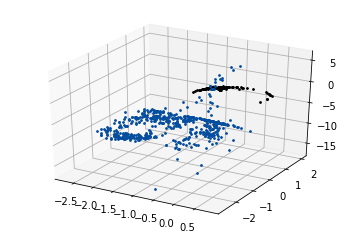

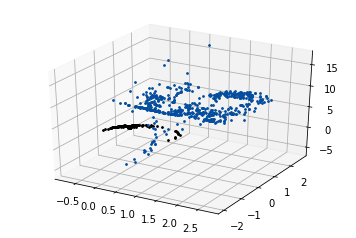

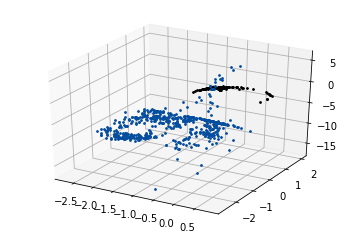

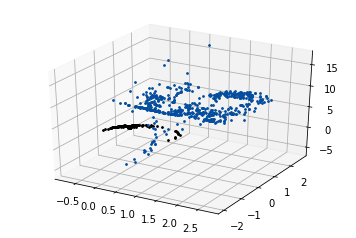

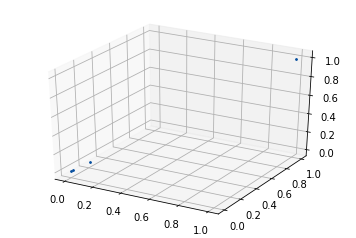

In [24]:
def linear_LS_Triangulation(x1, camera_matrix1, x2, camera_matrix2):
    '''
        ref: 1995 Triangulation, ch5.1 Linear Triangulation
        https://perception.inrialpes.fr/Publications/1997/HS97/HartleySturm-cviu97.pdf
    '''
    A = np.array([[(x1[0]*camera_matrix1[2,0]-camera_matrix1[0,0]), (x1[0]*camera_matrix1[2,1]-camera_matrix1[0,1]), (x1[0]*camera_matrix1[2,2]-camera_matrix1[0,2])],
                  [(x1[1]*camera_matrix1[2,0]-camera_matrix1[1,0]), (x1[1]*camera_matrix1[2,1]-camera_matrix1[1,1]), (x1[1]*camera_matrix1[2,2]-camera_matrix1[1,2])],
                  [(x2[0]*camera_matrix2[2,0]-camera_matrix2[0,0]), (x2[0]*camera_matrix2[2,1]-camera_matrix2[0,1]), (x2[0]*camera_matrix2[2,2]-camera_matrix2[0,2])],
                  [(x2[1]*camera_matrix2[2,0]-camera_matrix2[1,0]), (x2[1]*camera_matrix2[2,1]-camera_matrix2[1,1]), (x2[1]*camera_matrix2[2,2]-camera_matrix2[1,2])]])
    
    B = np.array([-(x1[0]*camera_matrix1[2,3]-camera_matrix1[0,3]),
                -(x1[1]*camera_matrix1[2,3]-camera_matrix1[1,3]),
                -(x2[0]*camera_matrix2[2,3]-camera_matrix2[0,3]),
                -(x2[1]*camera_matrix2[2,3]-camera_matrix2[1,3])])
    
    state, X = cv2.solve(A, B, flags=cv2.DECOMP_SVD)
    return state, X

def iterative_linear_LS_triangulation(u, p, u1, p1):
    '''
        ref: Triangulation, Hartley, R.I. and Sturm, P.
        http://www.morethantechnical.com/2012/01/04/simple-triangulation-with-opencv-from-harley-zisserman-w-code/
    '''
    wi, wi1 = 1, 1
    X = np.zeros((4,1))
    EPSILON = 0.1
    
    #Hartley suggests 10 iterations at most
    for i in range(10):
        s, aX = linear_LS_Triangulation(u, p, u1, p1)
        X = np.array([aX[0], aX[1], aX[2], 1])
        
        # recalculate weights
        p2x = np.dot(np.transpose(p[2]), X)
        p2x1 = np.dot(np.transpose(p1[2]), X)
        
        # breaking point
        if(abs(wi - p2x) <= EPSILON) and (abs(wi1 - p2x1) <= EPSILON):
            break
        
        # reweight equations and SVD
        A = np.array([[(u[0]*p[2,0] - p[0,0])/wi, (u[0]*p[2,1] - p[0,1])/wi, (u[0]*p[2,2] - p[0,2])/wi],
                     [(u[1]*p[2,0] - p[1,0])/wi, (u[1]*p[2,1] - p[1,1])/wi, (u[1]*p[2,2] - p[1,2])/wi],
                     [(u1[0]*p1[2,0] - p1[0,0])/wi1, (u1[0]*p1[2,1] - p1[0,1])/wi1, (u1[0]*p1[2,2] - p1[0,2])/wi1],
                     [(u1[1]*p1[2,0] - p1[1,0])/wi1, (u1[1]*p1[2,1] - p1[1,1])/wi1, (u1[1]*p1[2,2] - p1[1,2])/wi1]])
                      
        B = np.array([-(u[0]*p[2,3] - p[0,3])/wi,
                     -(u[1]*p[2,3] - p[1,3])/wi,
                     -(u1[0]*p1[2,3] - p1[0,3])/wi1,
                     -(u1[1]*p1[2,3] - p1[1,3])/wi1])
        state, aX = cv2.solve(A, B, flags=cv2.DECOMP_SVD)
    return aX
                      
def triangulate_points(keypts1, keypts2, kinv, kinv1, p, p1):
    
    if(kinv[-1,-1] != 1):
        kinv = kinv/kinv[-1,-1]
    if(kinv1[-1,-1] != 1):
        kinv1 = kinv1/kinv1[-1,-1]
    
    points = np.zeros((len(keypts1), 3))
    for i in range(len(keypts1)):
    
        # convert to normalized homogeneous coordinates
        kp1 = keypts1[i]
        x1 = np.array([kp1[0], kp1[1], 1])
        x1 = np.dot(kinv, x1)
        
        # convert to normalized homogeneous coordinates
        kp2 = keypts2[i]
        x2 = np.array([kp2[0], kp2[1], 1])
        x2 = np.dot(kinv1, x2)

        # triangulate
        points[i] = iterative_linear_LS_triangulation(x1, p, x2, p1)[:,0]
        
    return points        

def show_cloud_points(pts, cv_pts=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i, p in enumerate(pts):
        xs = pts[i][0]
        ys = pts[i][1]
        zs = pts[i][2]
        ax.scatter(xs, ys, zs, color='#054E9F', s=3)
        
    if(cv_pts is not None):
        for i in range(cv_pts.shape[1]):
            hp = cv_pts[:,i]
            #hp = hp/hp[-1]
            xs = hp[0]
            ys = hp[1]
            zs = hp[2]
            ax.scatter(xs, ys, zs, color='#000000', s=3)
    plt.show()

cloudpts1 = triangulate_points(imgpts1, imgpts2, np.linalg.inv(intrinsic_matrix1), np.linalg.inv(intrinsic_matrix2), projectmat1, projectmat2_1)
cloudpts2 = triangulate_points(imgpts1, imgpts2, np.linalg.inv(intrinsic_matrix1), np.linalg.inv(intrinsic_matrix2), projectmat1, projectmat2_2)
cloudpts3 = triangulate_points(imgpts1, imgpts2, np.linalg.inv(intrinsic_matrix1), np.linalg.inv(intrinsic_matrix2), projectmat1, projectmat2_3)
cloudpts4 = triangulate_points(imgpts1, imgpts2, np.linalg.inv(intrinsic_matrix1), np.linalg.inv(intrinsic_matrix2), projectmat1, projectmat2_4)

proj_points1 = imgpts1.reshape(2,-1)
proj_points2 = imgpts2.reshape(2,-1)

cloudpts1_cv = cv2.triangulatePoints(projectmat1, projectmat2_1, proj_points1, proj_points2)
cloudpts2_cv = cv2.triangulatePoints(projectmat1, projectmat2_1, proj_points1, proj_points2)
cloudpts3_cv = cv2.triangulatePoints(projectmat1, projectmat2_1, proj_points1, proj_points2)
cloudpts4_cv = cv2.triangulatePoints(projectmat1, projectmat2_1, proj_points1, proj_points2)
cloudpts5_cv = cv2.triangulatePoints(test_p1, test_p2, proj_points1, proj_points2)

show_cloud_points(cloudpts1, cloudpts1_cv)
show_cloud_points(cloudpts2, cloudpts2_cv)
show_cloud_points(cloudpts3, cloudpts3_cv)
show_cloud_points(cloudpts4, cloudpts4_cv)
show_cloud_points(cloudpts5_cv)

## 測試第二圖

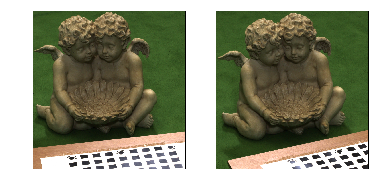

In [ ]:
image3 = cv2.imread('./data/Statue1.bmp')
image4 = cv2.imread('./data/Statue2.bmp')
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)

plt.subplot(121), plt.imshow(image3), plt.axis('off')
plt.subplot(122), plt.imshow(image4), plt.axis('off')
plt.show()

# get feature points
sift2 = cv2.xfeatures2d.SIFT_create()
(keypt3, desc3) = sift2.detectAndCompute(image3, None)
(keypt4, desc4) = sift2.detectAndCompute(image4, None)
BF_MACTHER_DISTANCE = 0.65
matches2 = hw3.brute_force_matcher(desc3, desc4, BF_MACTHER_DISTANCE)
matched_pt_order2 = hw3.sort_matched_points(matches2)
matched_feature_image = hw3.show_matched_image(image3, image4, keypt3, keypt4, matched_pt_order2, draw_line=False, circle_size=10)
plt.imshow(matched_feature_image), plt.axis('off'), plt.show()
imgpts3, imgpts4 = hw3.get_matched_points(matched_pt_order2, keypt3, keypt4)

k3 = np.array([[5426.566895, 0.678017, 330.096680],
             [0.000000, 5423.133301, 648.950012],
             [0.000000, 0.000000, 1.000000]])
r3 = np.array([[0.140626, 0.989027, -0.045273],
              [0.475766, -0.107607, -0.872965],
              [-0.868258, 0.101223, -0.485678]])
t3 = np.array([67.479439, -6.020049, 40.224911])
projectmat3 = get_camera_matrix(k3, r3, -np.dot(r3, t3))
print("projection matrix 3\n", projectmat3)

k4 = np.array([[5426.566895, 0.678017, 387.430023],
              [0.000000, 5423.133301, 620.616699],
              [0.000000, 0.000000, 1.000000]])
r4 = np.array([[0.336455, 0.940689, -0.043627],
              [0.446741, -0.200225, -0.871970],
              [-0.828988, 0.273889, -0.487611]])
t4 = np.array([62.882744, -21.081516, 40.544052])
projectmat4 = get_camera_matrix(k4, r4, -np.dot(r4, t4))
print("projection matrix 3\n", projectmat4)

cloudpts = triangulate_points(imgpts3, imgpts4, np.linalg.inv(k3), np.linalg.inv(k4), projectmat3, projectmat4)
show_cloud_points(cloudpts)